In [1]:
# Define Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, accuracy_score, precision_score, mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def clean_numeric(x, function='int'):
	try:
		if function == 'float':
			result = float(x)
		else: 
			result = int(x)
	except:
		result = np.nan
	return result

def clean_numeric_column(data, column_name, function='int'):
	imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
	result = imputer.fit_transform(np.array(data[column_name].apply(lambda x: clean_numeric(x, function))).reshape(-1,1)).flatten()
	return pd.Series(result)

def clean_all_columns(data):
	result = data.copy()
	for x in [('GPA', 'float'), 'Gender', 'breakfast', 'calories_chicken',	'calories_day', 'calories_scone', 'coffee', 
	'comfort_food_reasons_coded', 'cook', 'comfort_food_reasons_coded', 'cuisine', 'diet_current_coded', 'eating_changes_coded',
	'eating_changes_coded1', 'eating_out', 'employment', 'ethnic_food', 'exercise', 'father_education', 'fav_cuisine_coded', 'fav_food',
	'fries', 'fruit_day', 'grade_level', 'greek_food', 'ideal_diet_coded', 'income', 'indian_food', 'italian_food', 'life_rewarding', 'marital_status', 
	'mother_education', 'nutritional_check', 'on_off_campus', 'parents_cook', 'pay_meal_out', 'persian_food', 'self_perception_weight', 'soup', 'sports', 'thai_food', 'tortilla_calories', 'turkey_calories',
	'veggies_day', 'vitamins', 'waffle_calories', 'weight']:
		if type(x) == tuple:
			clean_column = clean_numeric_column(result, x[0], x[1])
			result.drop(labels=x[0], axis='columns', inplace=True)
			result[x[0]] = clean_column
		else:
			clean_column = clean_numeric_column(result, x, 'int')
			result.drop(labels=x, axis='columns', inplace=True)
			result[x] = clean_column
	return result

In [3]:
#load file
df=pd.read_csv("food_coded.csv")
df.head(5)

# ***** Data Cleaning
df_retain = clean_all_columns(df)
string_cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
df_retain = df_retain.iloc[:,15:]

print("**** List of All columns in a dataframe\n ")
print(list(df_retain.columns))




**** List of All columns in a dataframe
 
['GPA', 'Gender', 'breakfast', 'calories_chicken', 'calories_day', 'calories_scone', 'coffee', 'cook', 'comfort_food_reasons_coded', 'cuisine', 'diet_current_coded', 'eating_changes_coded', 'eating_changes_coded1', 'eating_out', 'employment', 'ethnic_food', 'exercise', 'father_education', 'fav_cuisine_coded', 'fav_food', 'fries', 'fruit_day', 'grade_level', 'greek_food', 'ideal_diet_coded', 'income', 'indian_food', 'italian_food', 'life_rewarding', 'marital_status', 'mother_education', 'nutritional_check', 'on_off_campus', 'parents_cook', 'pay_meal_out', 'persian_food', 'self_perception_weight', 'soup', 'sports', 'thai_food', 'tortilla_calories', 'turkey_calories', 'veggies_day', 'vitamins', 'waffle_calories', 'weight']



**** Before Simplification : Counts of each food in the data



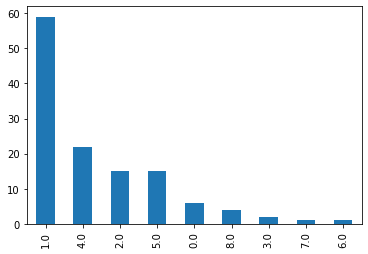

In [4]:
# Simplying data due to low training data avaialble
    # Removing 2,6,7 categroy due to low count
    # Adding 8 to 4 because indian food also comes under the umbrella of Asian food
    # Removing 0 because they are undecided and have low counts

print("\n**** Before Simplification : Counts of each food in the data\n")

CountStatus = pd.value_counts(df_retain['fav_cuisine_coded'].values, sort=True)
CountStatus.plot.bar()
df_retain.loc[df_retain['fav_cuisine_coded']==8] = 4
df_retain=df_retain[df_retain['fav_cuisine_coded'].isin([1,2,4,5])]






**** After Simplification : Counts of each food in the data



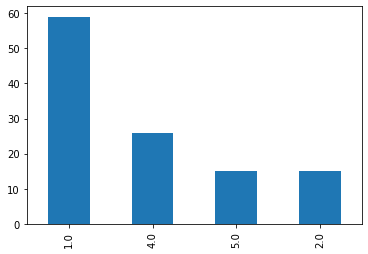

In [5]:
print("\n**** After Simplification : Counts of each food in the data\n")
CountStatus = pd.value_counts(df_retain['fav_cuisine_coded'].values, sort=False)
CountStatus.plot.bar()




**** After Simplification : Relative Frequency of each food in the data



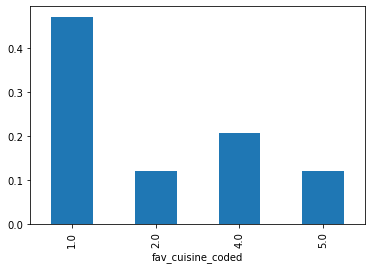

In [6]:
average_rate = ((df_retain.groupby(['fav_cuisine_coded']).fav_cuisine_coded.count())/len(df))
print("\n**** After Simplification : Relative Frequency of each food in the data\n")
average_rate.plot.bar()


In [7]:
#test-train split using stratification

# STRATIFIED SAMPLING 
X = df_retain.loc[:, df_retain.columns != 'fav_cuisine_coded']
y = df_retain[['fav_cuisine_coded']]


X_train, x_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.25)

# Training Set : X_train, y_train
# Testing Set : x_test , y_test




In [8]:
def feature_selection_RF(X_train, y_train):
    clf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    sfm = SelectFromModel(clf, threshold=0.025)
    sfm.fit(X_train, y_train)
    X_important_train = sfm.transform(X_train)
    
    clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf_important.fit(X_important_train, y_train)
    top__cols = list(X_train.columns[sfm.get_support(indices=True)])
    print("\n***** Top Features from Random Forest\n")
    print(top__cols)
    return top__cols

In [9]:
# Data Exploration
# scatter plots

#sns.set()
#sns.pairplot(X_train)
#plt.show();

In [10]:
# histograms

# %matplotlib inline
#X_train.hist(bins=50, figsize=(50,50))
#plt.show()

In [11]:
#Data Exploration based on Clustering

#df_new = df_retain.iloc[:,[25,13,7,]]
# Students with low income eat out less and tend to cook more

#df_new = df_retain.iloc[:,[11,13,34]]
# When eating changes are better, greater eating out and tend to pay more

#df_new = df_retain.iloc[:,[4,13,34]]
# Calories greater, eating out more, pay meal more (those going out & calories-aware are willing to pay more)

#df_new = df_retain.iloc[:,[13,33]]
# Eat out more if parents cook (Astonishlingly)

#df_new = df_retain.iloc[:,[25,33]]
# Income is less, parents cook more

df_new = df_retain.iloc[:,[11,9]]
#No relation b/w eating_changes_coded and cuisine

In [12]:
df_1 = pd.DataFrame(X,columns = df_new.columns)
from sklearn.cluster import KMeans
myKMC = KMeans(n_clusters = 2)
myKMC.fit(df_1)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_1.index.values
cluster_map['cluster'] = myKMC.labels_
results = pd.concat([df_1,cluster_map],axis=1,sort=False)
print(results.groupby(['cluster']).mean())

         eating_changes_coded   cuisine  data_index
cluster                                            
0.0                  1.659794  1.368270   61.471698
1.0                  1.222222  1.419753   84.666667


In [13]:
def correlation_matrix(df_1):
    from matplotlib.colors import ListedColormap
    
    corrMatrix = df.corr()
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(corrMatrix, annot=True,linewidths=.5, ax=ax)   
    plt.show()

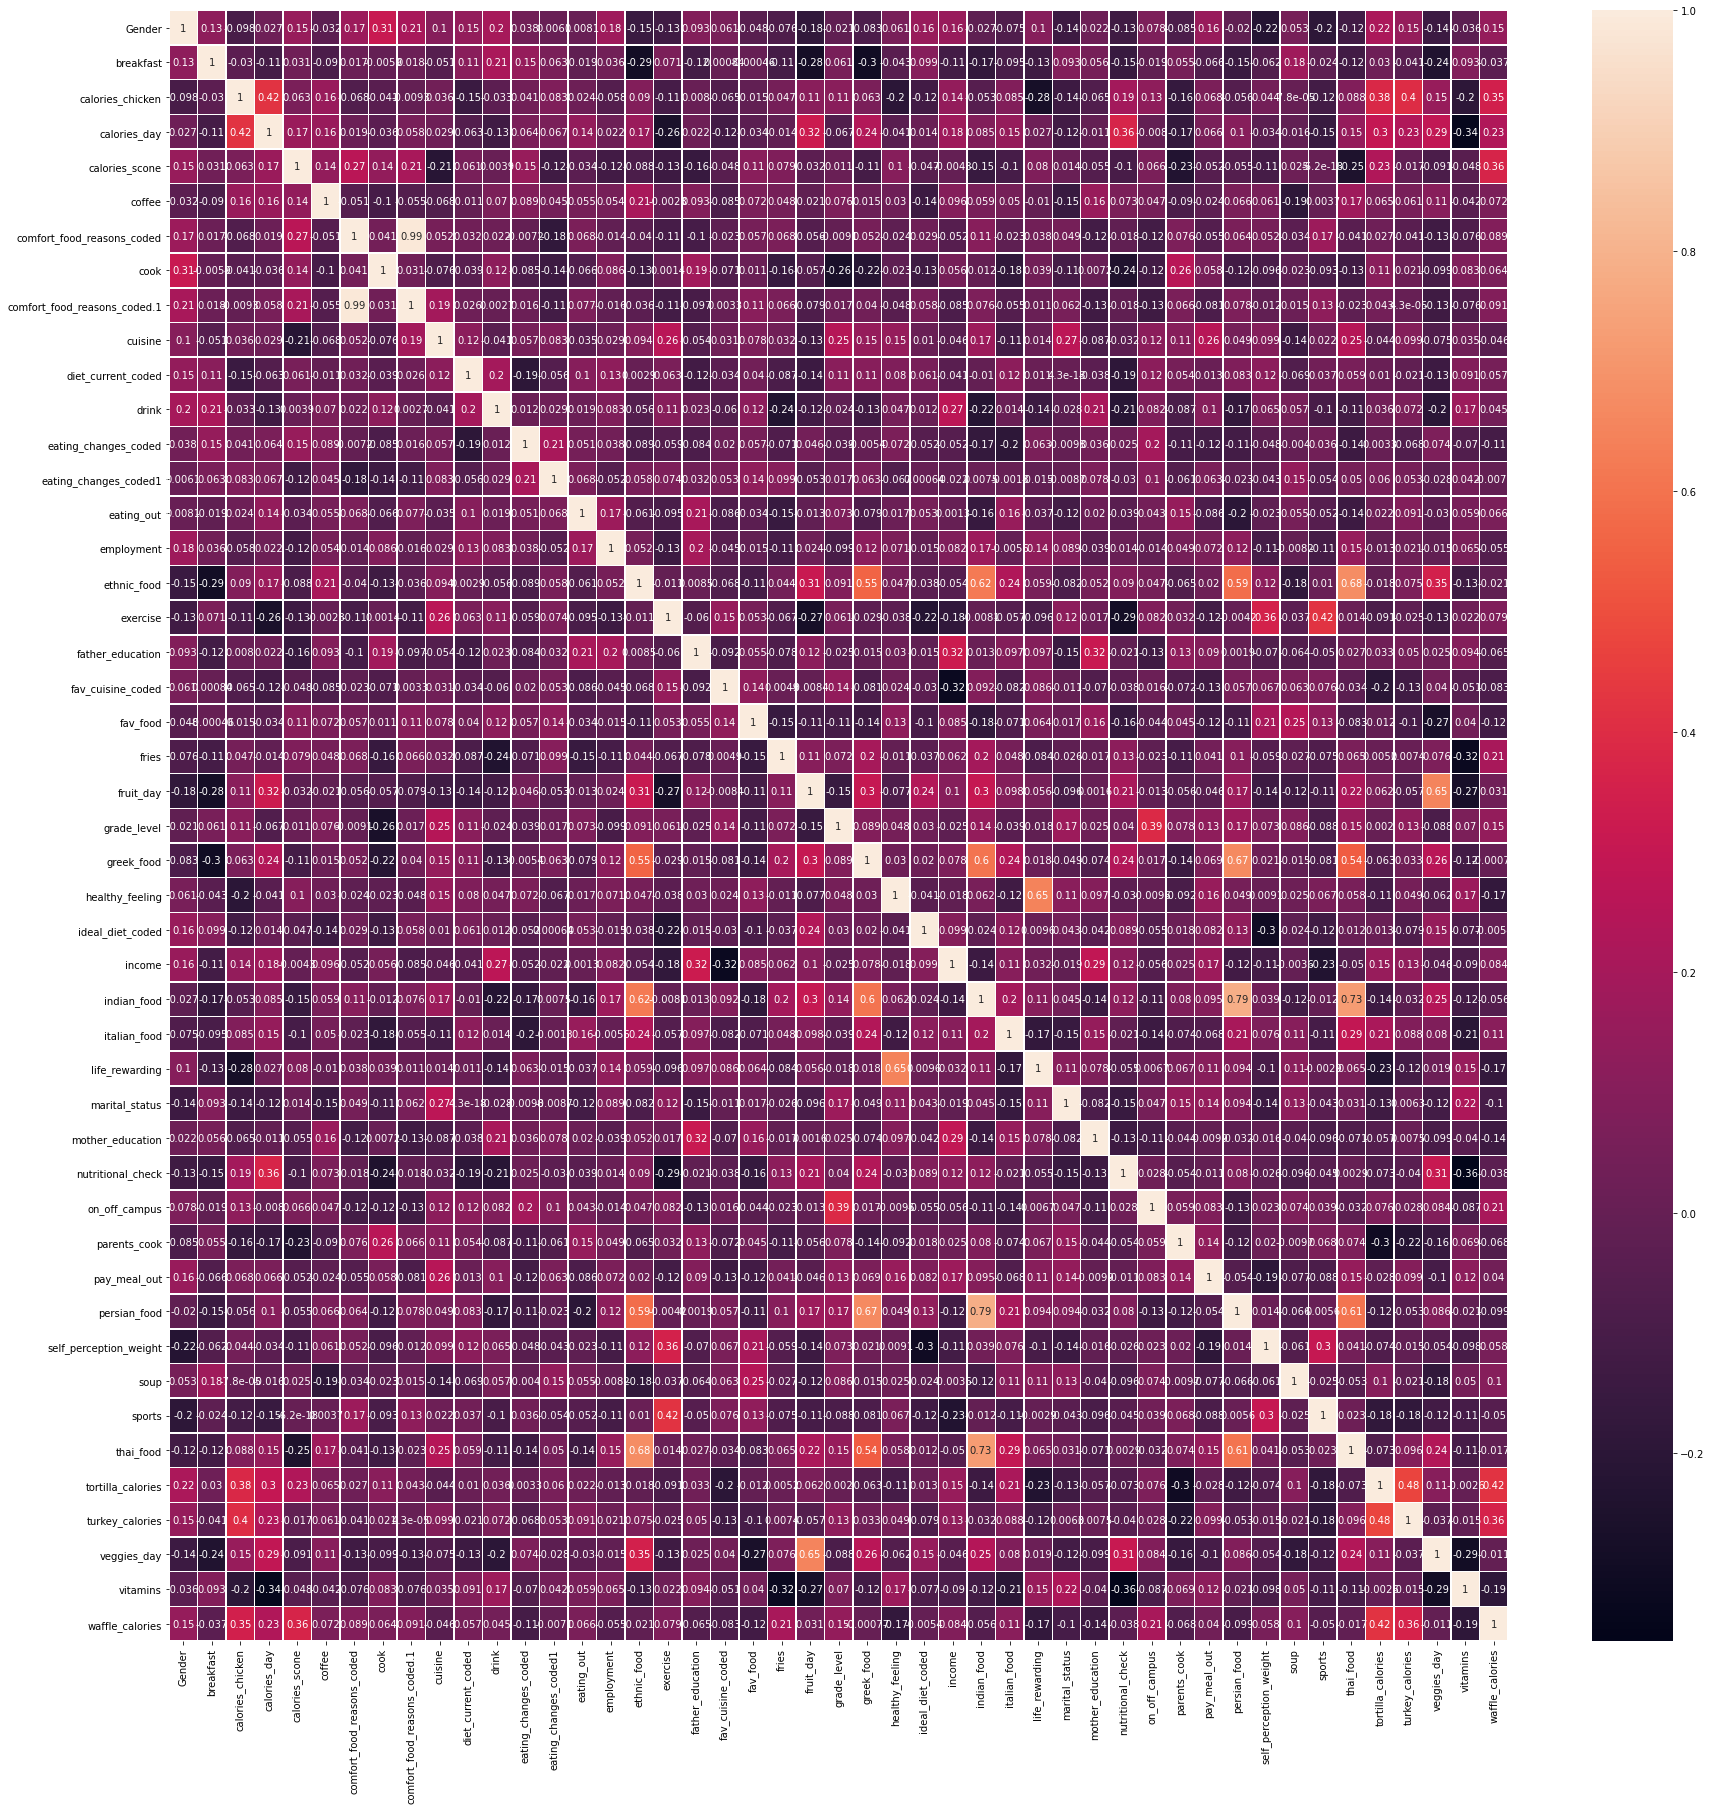

In [16]:
correlation_matrix(df_retain)

In [15]:
def chi_square_feature_sel(X_train,y_train,total_col_selected):
    df_train_chi_ind = X_train
    df_train_chi_dep = y_train
    
    bestfeatures = SelectKBest(score_func=chi2, k=20)
    fit = bestfeatures.fit(df_train_chi_ind,df_train_chi_dep)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_train_chi_ind.columns)
    
    #concat two dataframes for better visualization 
    
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    
    top_n_columns = featureScores.sort_values('Score',ascending=False).head(total_col_selected).Specs
    print("\n***** Top Features from Chi-Square \n")
    print(list(top_n_columns))
    return top_n_columns

In [17]:
top_n_cols = chi_square_feature_sel(X_train,y_train,20)
top_n_cols_RF = feature_selection_RF(X_train, y_train)

top_n_cols_final =  set(top_n_cols).intersection(set(top_n_cols_RF))
#top_n_cols.append('fav_cuisine_coded')

print("\n***** Top columns from joint techniques\n ")
print( set(top_n_cols) & set(top_n_cols_RF))

#Commenting others and proceeding with the data that gives best performance

# X_train =  X_train[X_train.columns.intersection(top_n_cols_final)]
# x_test =  x_test[x_test.columns.intersection(top_n_cols_final)]

top_n_cols=list(top_n_cols)
X_train =  X_train[X_train.columns.intersection(top_n_cols)]
x_test =  x_test[x_test.columns.intersection(top_n_cols)]

# X_train =  X_train[X_train.columns.intersection(top_n_cols_RF)]
# x_test =  x_test[x_test.columns.intersection(top_n_cols_RF)]




***** Top Features from Chi-Square 

['waffle_calories', 'tortilla_calories', 'calories_scone', 'turkey_calories', 'calories_chicken', 'weight', 'indian_food', 'persian_food', 'thai_food', 'ethnic_food', 'fav_food', 'breakfast', 'exercise', 'comfort_food_reasons_coded', 'fries', 'cuisine', 'soup', 'on_off_campus', 'coffee', 'income']

***** Top Features from Random Forest

['GPA', 'cook', 'eating_changes_coded1', 'greek_food', 'ideal_diet_coded', 'income', 'indian_food', 'life_rewarding', 'mother_education', 'pay_meal_out', 'persian_food', 'self_perception_weight', 'thai_food', 'tortilla_calories', 'turkey_calories', 'waffle_calories', 'weight']

***** Top columns from joint techniques
 
{'tortilla_calories', 'persian_food', 'income', 'thai_food', 'turkey_calories', 'waffle_calories', 'weight', 'indian_food'}


In [18]:
#standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)


scaler = StandardScaler()
scaler.fit(x_test) 
x_test = pd.DataFrame(scaler.transform(x_test),columns = x_test.columns)



In [19]:
#Grid search for finding right hyperparameter for Multinomial and One vs All Regression

from sklearn.model_selection import GridSearchCV

acc_scorer = make_scorer(accuracy_score)
#scoring = {'F1': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

grid={"C":np.logspace(-3,3,7),"multi_class":["multinomial","ovr",], "penalty":["l1","l2"], "solver":["lbfgs","saga","newton-cg"]} # l1 lasso l2 ridge
logreg=LogisticRegression(random_state=42)
logreg_cv=GridSearchCV(logreg, grid, cv=10, scoring = acc_scorer)
logreg_cv.fit(X_train,y_train)


print("Tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)


# Set the logreg_best to the best combination of parameters
logreg_best = logreg_cv.best_estimator_

# Fit the best algorithm to the data. 
logreg_best.fit(X_train, y_train)

logreg_est = logreg_best.predict(x_test)
accuracy_score(y_test, logreg_est)

print (logreg_est)

Tuned hpyerparameters :(best parameters)  {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.5805555555555555
[4. 1. 1. 1. 1. 5. 1. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 4. 1. 1. 5.
 4. 1. 1. 1. 1.]


Index(['income', 'cuisine', 'tortilla_calories', 'on_off_campus', 'exercise'], dtype='object')
(0.4, 0.3, 0.29, -0.22, -0.19)
Index(['fav_food', 'comfort_food_reasons_coded', 'on_off_campus',
       'waffle_calories', 'coffee'],
      dtype='object')
(-0.23, 0.28, 0.27, 0.27, 0.23)
Index(['tortilla_calories', 'ethnic_food', 'exercise',
       'comfort_food_reasons_coded', 'waffle_calories'],
      dtype='object')
(-0.3, 0.26, 0.26, -0.19, -0.18)
Index(['coffee', 'ethnic_food', 'thai_food', 'income', 'fav_food'], dtype='object')
(-0.34, -0.33, -0.25, -0.21, 0.23)


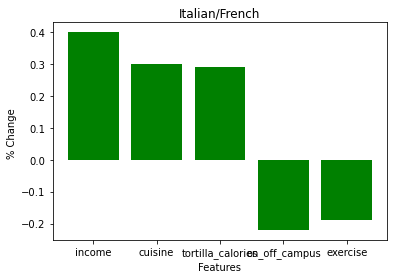

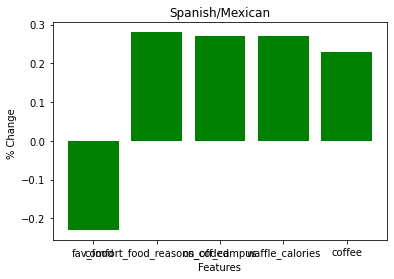

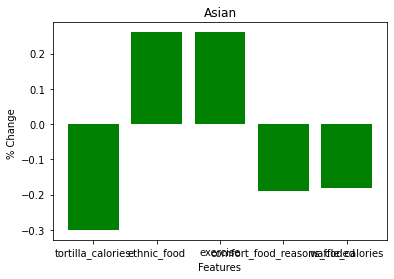

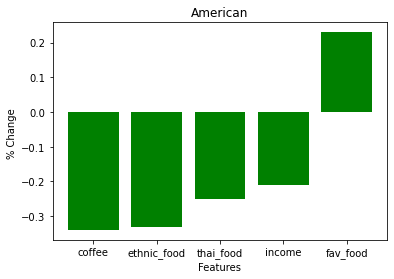

In [22]:
#print(np.exp(logreg_best.coef_))

#for (i,names) in enumerate(X_train.columns):
    #print (i," : ",names)

for j in range(4):
    feature_importance = abs(logreg_best.coef_[j])
    absolute_feature_importance = abs(logreg_best.coef_[j])
    feature_importance = np.exp(logreg_best.coef_[j])
    feature_importance = [x - 1 for x in feature_importance]
    feature_importance = list(np.around(np.array(feature_importance),2))
    from operator import itemgetter 
    top_features = sorted(range(len(absolute_feature_importance)), key=lambda i: absolute_feature_importance[i], reverse=True)[:5]
    top_features_values = itemgetter(*top_features)(feature_importance)
    top_features_column = X_train.columns[top_features]
    print(top_features_column)
    print(top_features_values)
    fig = plt.figure()
    food_list=['Italian/French' , 'Spanish/Mexican' , 'Asian' , 'American']
    plt.title(''+food_list[j])
    plt.xlabel('Features')
    
    plt.ylabel('% Change ')
    ax = plt.subplot()
    ax.bar(list(top_features_column), list(top_features_values), width=0.8,color='g')
    

In [21]:
#Grid search for finding right hyperparameter for Gradient Boost Classification

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators":[10]
#     }

#Using a subset of parameters for early computation, more parameters could be added from above sample

parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6],
    "n_estimators":[10, 20, 30, 40 ,50, 60, 70, 80, 90, 100]
    }

acc_scorer = make_scorer(accuracy_score)

grad_cv = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters, cv=10, scoring=acc_scorer)
grad_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",grad_cv.best_params_)
print("accuracy :",grad_cv.best_score_)

# Set the grad_best to the best combination of parameters
grad_best = grad_cv.best_estimator_

# Fit the best algorithm to the data. 
grad_best.fit(X_train, y_train)

grad_est = grad_best.predict(x_test)
accuracy_score(y_test, grad_est)

print (grad_est)

KeyboardInterrupt: 

In [ ]:
#Grid search for finding right hyperparameter for Ada Boost Classification

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6],
    "n_estimators":[10, 20, 30, 40 ,50, 60, 70, 80, 90, 100]
    }

acc_scorer = make_scorer(accuracy_score)

ada_cv = GridSearchCV(AdaBoostClassifier(random_state=42), parameters, cv=10, scoring=acc_scorer)
ada_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",ada_cv.best_params_)
print("accuracy :",ada_cv.best_score_)

# Set the ada_best to the best combination of parameters
ada_best = ada_cv.best_estimator_

# Fit the best algorithm to the data. 
ada_best.fit(X_train, y_train)

ada_est = ada_best.predict(x_test)
accuracy_score(y_test, ada_est)

print (ada_est)

In [ ]:
#Ensemble learning implementation, with Logistic Regression (Multinomial or OVA), Gradient and Ada-Boost 

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss

voting_clf = VotingClassifier(estimators=[('LRM', logreg_best), ('GDB', grad_best), ('ADB', ada_best)], voting='soft')
voting_clf.fit(X_train, y_train)

preds = voting_clf.predict(x_test)
acc = accuracy_score(y_test, preds)

print("Accuracy is: " + str(acc))
print (preds)

In [ ]:
#test-train split using StratifiedKFold that also shuffles the data

from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

cv = StratifiedKFold(n_splits=5)
for train, test in cv.split(X,y):
    print(train)

In [ ]:
#Function for visualization of K-fold Stratified Sampling with 5 splits

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks, cmap='gray_r')
    
plot_cv(StratifiedKFold(n_splits=5),X,y)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(voting_clf, X, y, cv=cv)
print(scores)
print("Mean:", np.mean(scores.mean()))
print("Standard deviation:", np.mean(scores.std()))

#Small SD indicates that the model doesn't overfit to a particular chunk of a data

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
# multilabel_confusion_matrix(y_test, preds)

In [ ]:
from sklearn.metrics import confusion_matrix

classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
#confusion_matrix(y_test, preds)

In [ ]:
# print or plot  metrics / results

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
print(classification_report(y_test, preds, target_names=classes))

cm = confusion_matrix(y_test, preds)
classes = ['Italian/French/Greek', 'Spanish/mexican', 'Asian/Chinese/Thai/Nepal/Indian', 'American']
fig = plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion matrix for Ensemble')
plt.colorbar()
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

normalize = False
fmt = '.2f' if normalize else 'd'

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [ ]:
#Calculating lifts for the selected model

#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#The diagonal entries are the accuracies of each class
predicted_values = cm.diagonal()

print("Lift for Italian/French/Greek:", predicted_values[0]/average_rate[1])
print("Lift for Spanish/mexican:", predicted_values[1]/average_rate[2])
print("Lift for Asian/Chinese/Thai/Nepal/Indian:", predicted_values[2]/average_rate[4])
print("Lift for American:", predicted_values[3]/average_rate[5])

In [ ]:
# Final hold-out sample testing